# Pdet calculation with logistic regression

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import pycbc
from ler import LeR
from gwsnr import GWSNR 
import bilby

In [2]:
GWSNR?

Init signature:
GWSNR(
    npool=4,
    mtot_min=2.0,
    mtot_max=439.6,
    nsamples_mtot=100,
    nsamples_mass_ratio=50,
    sampling_frequency=2048.0,
    waveform_approximant='IMRPhenomD',
    minimum_frequency=20.0,
    snr_type='interpolation',
    waveform_inspiral_must_be_above_fmin=False,
    psds=None,
    psd_file=False,
    ifos=None,
    interpolator_dir='./interpolator_pickle',
)
Docstring:      <no docstring>
Init docstring:
Initialized parameters and functions
snr_half_scaled() : function for finding (f/PSD) integration in the limit [f_min,f_max]
list_of_detectors :  list of detector initials, e.g. L1 for Livingston
f_min : minimum frequency for the detector
-----------------
input parameters
-----------------
mtot_min           : minimum value of Mtotal=mass_1+mass_2, use in interpolation
mtot_max           : maximum value of Mtotal=mass_1+mass_2, use in interpolation
nsamples           : number of points you want to use for SNR interpolation (here it is half SNR not

In [4]:
gwsnr = GWSNR(
    npool=4,
    mtot_min=2.0,
    mtot_max=439.6,
    nsamples_mtot=200,
    nsamples_mass_ratio=500,
    sampling_frequency=2048.0,
    waveform_approximant='IMRPhenomXPHM',
    minimum_frequency=20.0,
    snr_type='interpolation',
    waveform_inspiral_must_be_above_fmin=False,
    psds=None,
    psd_file=False,
    ifos=None,
    interpolator_dir='./interpolator_pickle',
)

Given: IMR waveform, {self.waveform_approximant}.
psds not given. Choosing bilby's default psds
given psds:  {'L1': 'aLIGO_O4_high_asd.txt', 'H1': 'aLIGO_O4_high_asd.txt', 'V1': 'AdV_asd.txt'}
Interpolator will be loaded for L1 detector from ./interpolator_pickle/L1/halfSNR_dict_5.pickle
Interpolator will be loaded for H1 detector from ./interpolator_pickle/H1/halfSNR_dict_5.pickle
Interpolator will be loaded for V1 detector from ./interpolator_pickle/V1/halfSNR_dict_5.pickle


In [14]:
bilby.core.utils.logger.disabled = True
prior_default = bilby.gw.prior.BBHPriorDict()

In [23]:
# luminosity distance
nsamples = 10000
dL = prior_default['luminosity_distance'].sample(nsamples)
# mass prior
m1 = prior_default['mass_1'].sample(nsamples)
m2 = prior_default['mass_2'].sample(nsamples)

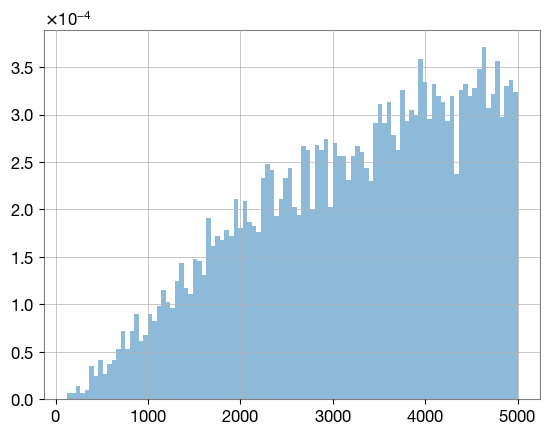

In [16]:
# plot histogram of dL
plt.hist(dL, bins=100, density=True, alpha=0.5, label='dL')
plt.show()

In [ ]:
nsamples = 10000
batch = 10000
# specify minimum and maximum redshift
zmin = 0.01
zmax = 2
# specify minimum and maximum mass
mmin = 2
mmax = 439.6

# convert redshift to luminosity distance
from astropy.cosmology import Planck18
dL_min = Planck18.luminosity_distance(zmin).value 
dL_max = Planck18.luminosity_distance(zmax).value
# print("Step 2: Simulation of unlensed CBCs")
# get priors

# assume 
snr_th = 8
# data1 (snr<7), data2 (7<snr<9), data3 (snr>9)
data1, data2, data3 = [], [], []

while True:
    # draw associated angles
    ra = prior_default["ra"].sample(nsamples)
    dec = prior_default["dec"].sample(nsamples)
    psi = prior_default["psi"].sample(nsamples)
    theta_jn = prior_default["theta_jn"].sample(nsamples)
    phase = prior_default["phase"].sample(nsamples)
    a_1 = prior_default["a_1"].sample(nsamples)
    a_2 = prior_default["a_2"].sample(nsamples)
    tilt_1 = prior_default["tilt_1"].sample(nsamples)
    tilt_2 = prior_default["tilt_2"].sample(nsamples)
    phi_12 = prior_default["phi_12"].sample(nsamples)
    phi_jl = prior_default["phi_jl"].sample(nsamples)

    # draw masses with uniform prior in m1 and m2
    m_1 = np.random.uniform(low=mmin, high=mmax, size=nsamples)
    m_2 = np.random.uniform(low=mmin, high=mmax, size=nsamples)
    # if m_1 < m_2, swap them
    m_1, m_2 = np.where(m_1 < m_2, (m_2, m_1), (m_1, m_2))
    # draw luminosity distance
    dL = np.random.uniform(low=dL_min, high=dL_max, size=nsamples)

    # calculate snr
    snr = gwsnr.snr(m_1, m_2, dL, ra, dec, psi, theta_jn, phase, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl)

    # populate data1, data2, data3
    if len(data1)<batch:
        data1.append([m_1, m_2, dL, ra, dec, psi, theta_jn, phase, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl])
    elif len(data2)<batch:
        data2.append([m_1, m_2, dL, ra, dec, psi, theta_jn, phase, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl])
    elif len(data3)<batch:
        data3.append([m_1, m_2, dL, ra, dec, psi, theta_jn, phase, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl])
    else:
        break

data1 = np.array(data1)
data2 = np.array(data2)
data3 = np.array(data3)


In [13]:
dL

4.434262480323607